# Characterizing Drought Duration and Severity with Copulas

We'll use paleo-reconstructed Palmer Drought Sseverity Index (PDSI) estimates from https://www.treeflow.info/sites/default/files/east_colo_pdsi.txt to build a model of the relationship between drought duration and severity.

In [1]:
!pip install lmoments3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import pandas as pd

# allow access to google drive
drive.mount('/content/drive')

!cp "drive/MyDrive/Colab Notebooks/CE6280/CodingExamples/utils.py" .
from utils import *

PDSI = pd.read_csv('drive/MyDrive/Colab Notebooks/CE6280/Data/EasternCO_PDSI.csv')

Mounted at /content/drive


Create functions to find drought periods (clusters), and then compute the duration and severity of droughts over those periods.

In [3]:
import numpy as np

# find all droughts, defined as consecutive periods below the mean
def findClusters(indices):
  allClusters = []
  subCluster = [indices[0]]
  for i in range(1,len(indices)):
    if indices[i] - subCluster[-1] <= 1:
      subCluster.append(indices[i])
    else:
      allClusters.append(subCluster)
      subCluster = [indices[i]]

  allClusters.append(subCluster)

  return allClusters

def findDandS(droughts, variable):
  durations = np.zeros(len(droughts))
  severities = np.zeros(len(droughts))
  for i,d in enumerate(droughts):
    durations[i] = len(d)
    severities[i] = -np.sum(variable[d[0]:(d[-1]+1)])

  return durations, severities

Find drought periods (when PDSI $<$0) and their duration and severity.

In [4]:
drought_indices = np.where(PDSI['reconPDSI'] < 0)[0]
droughts = findClusters(drought_indices)

durations, severities = findDandS(droughts, PDSI['reconPDSI'])

## Fitting Marginal Distributions

### Drought Severity

Visualize the distribution of drought severity.

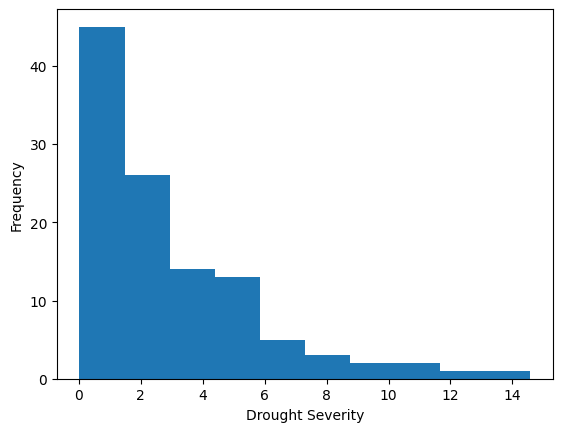

In [5]:
import matplotlib.pyplot as plt

plt.hist(severities)
plt.xlabel('Drought Severity')
plt.ylabel('Frequency')
plt.show()

The drought severities are positively skewed. Let's see if we can fit them with a log-normal distribution.

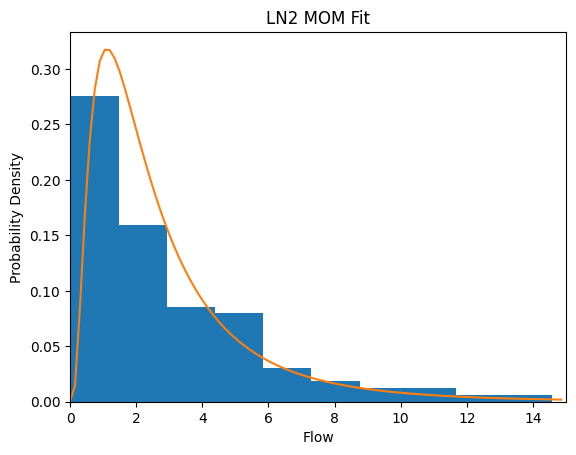

LN2 MOM mu: 0.76
LN2 MOM sigma: 0.81
LN2 MOM tau: 0.00




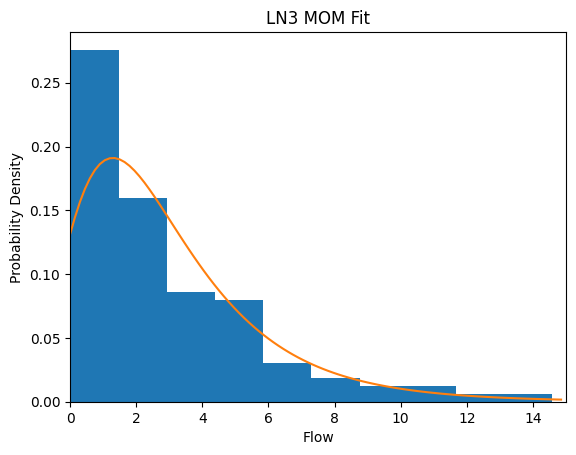

LN3 MOM mu: 1.55
LN3 MOM sigma: 0.50
LN3 MOM tau: -2.37




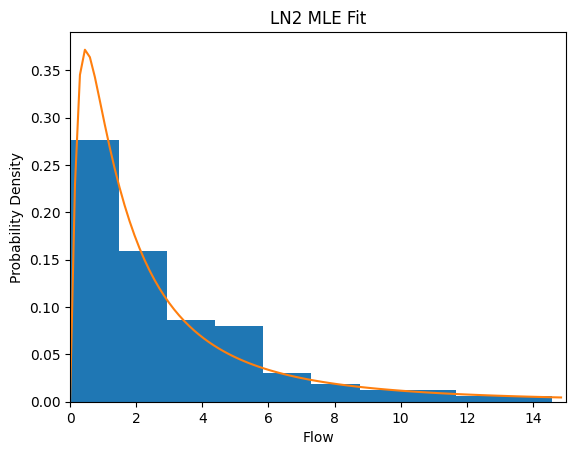

LN2 MLE mu: 0.60
LN2 MLE sigma: 1.16
LN2 MLE tau: 0.00




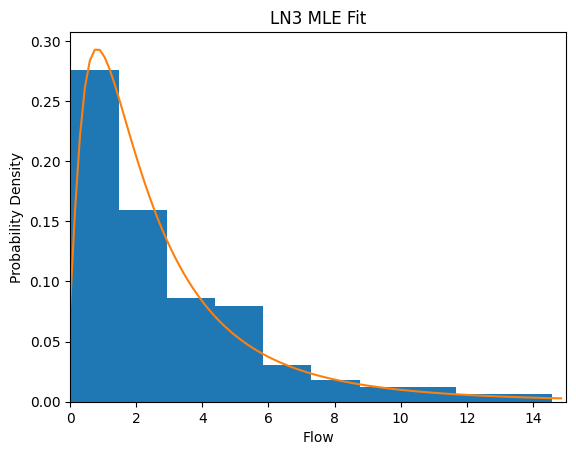

LN3 MLE mu: 0.83
LN3 MLE sigma: 0.86
LN3 MLE tau: -0.27




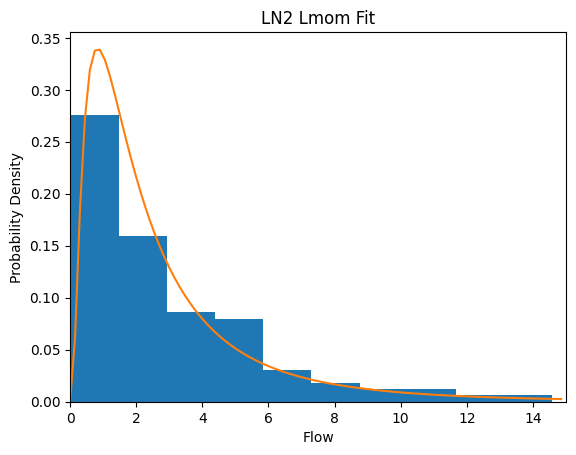

LN2 Lmom mu: 0.67
LN2 Lmom sigma: 0.92
LN2 Lmom tau: 0.00




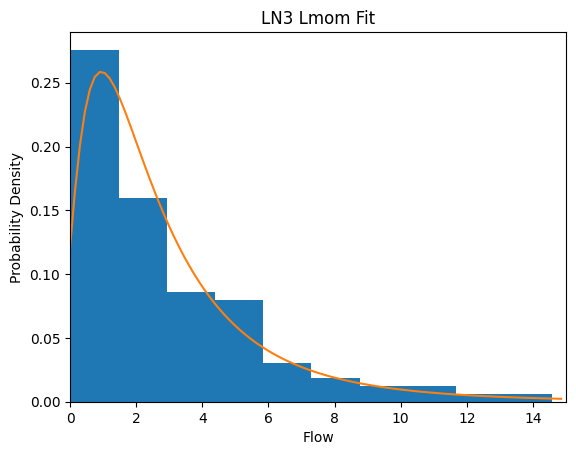

LN3 Lmom mu: 1.01
LN3 Lmom sigma: 0.74
LN3 Lmom tau: -0.63




In [6]:
methods = ["MOM", "MLE", "Lmom"]
npars = [2, 3]

for method in methods:
  for npar in npars:
    distfit = LogNormal()
    distfit.fit(severities, method, npar)
    distfit.plotHistPDF(severities, 0, 15, "LN" + str(npar) + " " + str(method) + " Fit")
    print("LN%d %s mu: %0.2f" % (npar, method, distfit.mu))
    print("LN%d %s sigma: %0.2f" % (npar, method, distfit.sigma))
    print("LN%d %s tau: %0.2f" % (npar, method, distfit.tau))
    print("\n")

The LN2 distribution fit with MLE visually fits well and has a lower bound of 0, whereas some of the LN3 distributions have negative lower bounds, which is not physically possible. So we will proceed with the LN2 MLE fit.

In [7]:
distfit = LogNormal()
distfit.fit(severities, 'MLE', 2)

### Drought Duration

Visualize the distribution of drought duration.

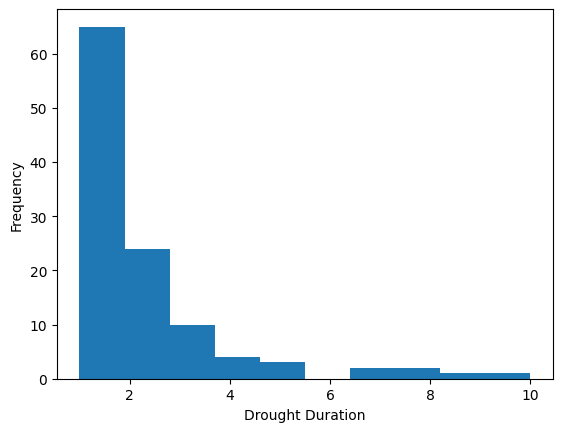

In [8]:
import matplotlib.pyplot as plt

plt.hist(durations)
plt.xlabel('Drought Duration')
plt.ylabel('Frequency')
plt.show()

This is a positively skewed, discrete distribution. Two possible discrete distributions that could fit this data are the geometric and Poisson distributions. Below we write classes for these distributions and test their goodness of fit with PPCC tests.

In [9]:
from scipy import stats as ss
from lmoments3 import distr

class Geom(Distribution):
  def __init__(self):
    super().__init__()
    self.p = None

  def ppccTest(self, data, title, m=10000):
    # calculate test statistic, rho
    x_sorted = np.sort(data)
    p_observed = ss.mstats.plotting_positions(x_sorted)
    x_fitted = ss.geom.ppf(p_observed, self.p)
    self.ppcc_rho = np.corrcoef(x_sorted, x_fitted)[0,1]

    # generate m synthetic samples of n observations to estimate null distribution of rho
    rhoVector = np.zeros(m)
    for i in range(m):
      np.random.seed(i)
      x = ss.geom.rvs(self.p, size=len(data))
      rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0,1]

    # calculate p-value of test and make QQ plot
    count = 0
    for i in range(len(rhoVector)):
      if self.ppcc_rho < rhoVector[i]:
        count = count + 1

    self.p_value_PPCC = 1 - count/(len(rhoVector) + 1)

    # make Q-Q plot
    plt.scatter(x_sorted,x_fitted,color='b')
    plt.plot(x_sorted,x_sorted,color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.show()

class Poisson(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None

  def ppccTest(self, data, title, m=10000):
    # calculate test statistic, rho
    x_sorted = np.sort(data)
    p_observed = ss.mstats.plotting_positions(x_sorted)
    x_fitted = ss.poisson.ppf(p_observed, self.mu)
    self.ppcc_rho = np.corrcoef(x_sorted, x_fitted)[0,1]

    # generate m synthetic samples of n observations to estimate null distribution of rho
    rhoVector = np.zeros(m)
    for i in range(m):
      np.random.seed(i)
      x = ss.poisson.rvs(self.mu, size=len(data))
      rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0,1]

    # calculate p-value of test and make QQ plot
    count = 0
    for i in range(len(rhoVector)):
      if self.ppcc_rho < rhoVector[i]:
        count = count + 1

    self.p_value_PPCC = 1 - count/(len(rhoVector) + 1)

    # make Q-Q plot
    plt.scatter(x_sorted,x_fitted,color='b')
    plt.plot(x_sorted,x_sorted,color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.show()

Let's see if the Poisson distribution captures the drought durations. The Poisson distribution has one parameter $\mu$ that is estimated as the mean for both MOM and MLE:

$f_X(k) = P(X=k) = \exp(-\mu) \frac{\mu^k}{k!}$  
$\mu = E[X] \approx \bar{x}$.

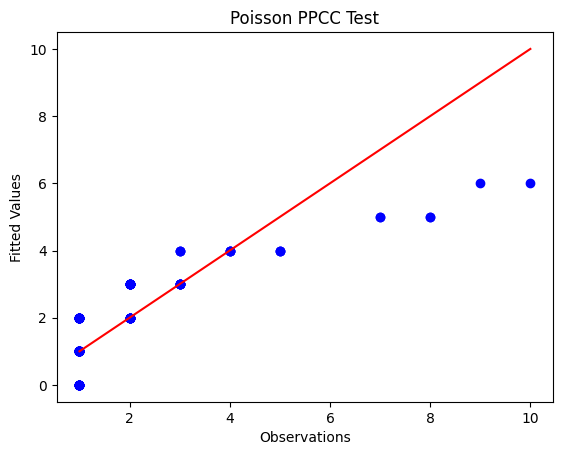

Poisson p-value: 9.999000099991662e-05


In [10]:
poiss_fit = Poisson()
poiss_fit.mu = np.mean(durations)
poiss_fit.ppccTest(durations, 'Poisson PPCC Test')
print('Poisson p-value:', poiss_fit.p_value_PPCC)

We strongly reject this fit! How about a geometric distribution? This distribution has one parameter $p$, which is estimated as the inverse of the mean using both MOM and MLE:

$f_x(k) = P(X=k) = (1-p)^{k-1}p$  
$p = \frac{1}{E[X]} \approx \frac{1}{\bar{x}}$.

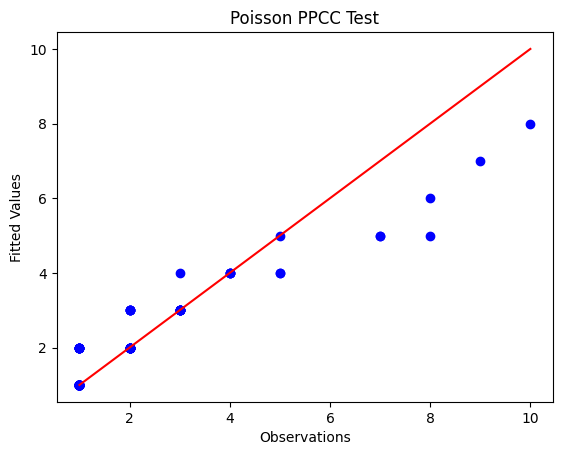

Poisson p-value: 0.08469153084691527


In [11]:
geom_fit = Geom()
geom_fit.p = 1/np.mean(durations)
geom_fit.ppccTest(durations, 'Poisson PPCC Test')
print('Poisson p-value:', geom_fit.p_value_PPCC)

We do not reject this fit at the 5\% level, but we do at the 10\% level, so it is not a very strong fit. For this reason, we'll just use the empirical distribution. This has the advantage of fitting the data perfectly, but the disadvantage of not enabling durations beyond what has been observed in the historical record.

## Converting Real-Space Values to "U-Space" values through the Marginal CDFs.

Correlation in U-space: 0.48


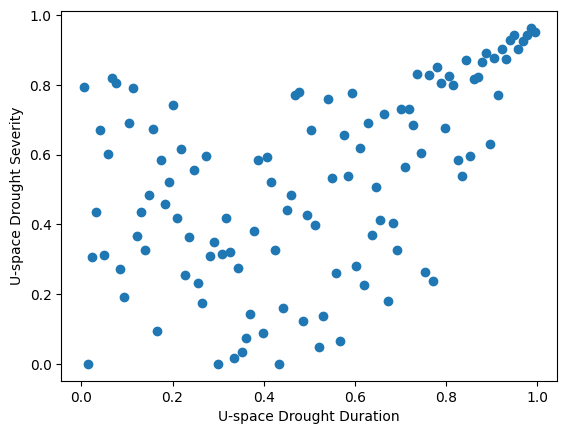

In [12]:
u_S = ss.lognorm.cdf(severities, distfit.sigma, distfit.tau, np.exp(distfit.mu))
u_D = ss.mstats.plotting_positions(durations)

rho = np.corrcoef(u_D, u_S)[0,1]
print("Correlation in U-space: %0.2f" % rho)

plt.scatter(u_D, u_S)
plt.xlabel('U-space Drought Duration')
plt.ylabel('U-space Drought Severity')
plt.show()

The overall correlation coefficient is moderate at 0.48. However, the correlation seems weak for short durations, but high for long durations, showing upper tail dependence. The Gumbel and Joe copulas exhibit upper tail dependence, while the Clayton copula exhibits lower tail dependence. Therefore, we could try directly fitting Gumbel and Joe copulas, and we could also fit a Clayton copula to 1-u, as that would reverse the tail dependence (see figure below).

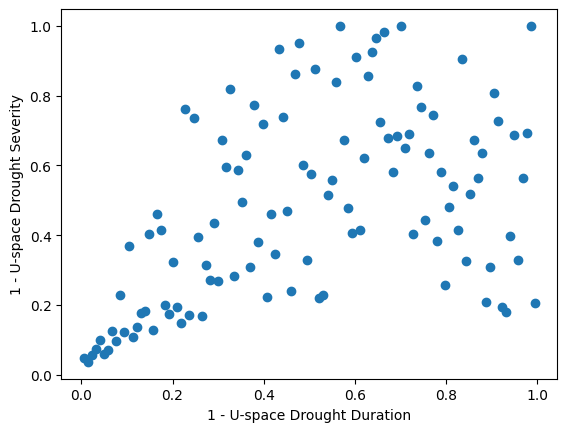

In [13]:
plt.scatter(1-u_D, 1-u_S)
plt.xlabel('1 - U-space Drought Duration')
plt.ylabel('1 - U-space Drought Severity')
plt.show()

## Fitting Bivariate Copulas to U-Space Variables

In [14]:
!pip install pyvinecopulib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00


In [15]:
import pyvinecopulib as pv

u = np.vstack((u_D, u_S)).T

GumbelCop = pv.Bicop(pv.BicopFamily.gumbel)
GumbelCop.fit(data=u)
print(GumbelCop)
print("AIC: %0.2f" % GumbelCop.aic())
print("BIC: %0.2f" % GumbelCop.bic())
print("log-likelihood: %0.2f" % GumbelCop.loglik())

<pyvinecopulib.Bicop>
Bivariate copula: 
  family = Gumbel
  rotation = 0
  var_types = c,c
  parameters = 1.7

AIC: -48.60
BIC: -45.89
log-likelihood: 25.30


In [16]:
JoeCop = pv.Bicop(pv.BicopFamily.joe)
JoeCop.fit(data=u)
print(JoeCop)
print("AIC: %0.2f" % JoeCop.aic())
print("BIC: %0.2f" % JoeCop.bic())
print("log-likelihood: %0.2f" % JoeCop.loglik())

<pyvinecopulib.Bicop>
Bivariate copula: 
  family = Joe
  rotation = 0
  var_types = c,c
  parameters = 2.4

AIC: -63.49
BIC: -60.77
log-likelihood: 32.75


In [17]:
ClaytonCop = pv.Bicop(pv.BicopFamily.clayton)
ClaytonCop.fit(data=1-u)
print(ClaytonCop)
print("AIC: %0.2f" % ClaytonCop.aic())
print("BIC: %0.2f" % ClaytonCop.bic())
print("log-likelihood: %0.2f" % ClaytonCop.loglik())

<pyvinecopulib.Bicop>
Bivariate copula: 
  family = Clayton
  rotation = 0
  var_types = c,c
  parameters = 1.6

AIC: -60.90
BIC: -58.18
log-likelihood: 31.45


In [18]:
controls = pv.FitControlsBicop(parametric_method="mle", selection_criterion="bic")

BestCop = pv.Bicop.from_data(data=u, controls=controls)
print(BestCop)

print("AIC: %0.2f" % BestCop.aic())
print("BIC: %0.2f" % BestCop.bic())
print("log-likelihood: %0.2f" % BestCop.loglik())

<pyvinecopulib.Bicop>
Bivariate copula: 
  family = Joe
  rotation = 0
  var_types = c,c
  parameters = 2.4

AIC: -63.49
BIC: -60.77
log-likelihood: 32.75


## Testing Goodness of Fit with Cramer von Mises test

The Cramer von Mises test statistic is:

$\omega^2 = \sum_{i=1}^n [S_n(x_i) - S_n^*(x_i)]^2$  
where  
$S_n(x_i)$ and $S_n^*(x_i)$ are the empirical and fitted copulas:  
$S_n(x_i) = \frac{1}{n+1} \sum_{i=1}^n \mathbb{1} \{P(C(u_i)<x_i)\}$ and  
$S_n^*(x_i) = P(C(u)<x_i)$

We can use a Monte Carlo simulation from the fitted copula to compute the null distribution of $\omega^2$. If our test statistic is above more than 95\% of them, we reject that the data came from the fitted copula at a significance level of 0.05. The p-value is the percent of simulated test statistics that are greater than the observed test statistic.

The functions below computes the test statistic and p-value of the Cramer von Mises test.

In [121]:
def compute_omegaSq(data, cop):
  n = len(data)
  omegaSq = 0
  for i in range(n):
    count = len(np.where(np.all(data <= data[i,:]))[0])
    omegaSq += (count/(n+1) - cop.cdf(np.array([data[i,:]]))[0])**2

  return omegaSq

def cramer_von_mises(data, cop, m=1000):
  # compute test statistic, omegaSq
  omegaSq = compute_omegaSq(data, cop)

  # generate m synthetic samples of n observations to estimate null distribution of omegaSq
  omegaSqVector = np.zeros(m)
  for i in range(m):
    uSim = cop.simulate(len(data), qrng=True, seeds=[i])
    omegaSqVector[i] = compute_omegaSq(uSim, cop)

  # calculate p-value of test
  p_value = len(np.where(omegaSqVector > omegaSq)[0]) / (len(omegaSqVector) + 1)

  return p_value

Let's compute the p-value for each fitted distribution.

In [122]:
p_Gumbel = cramer_von_mises(u, GumbelCop)
p_Joe = cramer_von_mises(u, JoeCop)
p_Clayton = cramer_von_mises(1-u, ClaytonCop)

print("Gumbel p-value: %0.2f" % p_Gumbel)
print("Joe p-value: %0.2f" % p_Joe)
print("Clayton p-value: %0.2f" % p_Clayton)

<ipython-input-121-1977b91e74de>:5: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  count = len(np.where(np.all(data <= data[i,:]))[0])


Gumbel p-value: 0.08
Joe p-value: 0.59
Clayton p-value: 1.00


This suggests the Clayton copula is the best, which differs from the other metrics. We'll show fits from both.

## Plotting Fitted Bivariate Copulas

3D PDF. Keep in mind the quantiles are reversed for the Clayton copula.

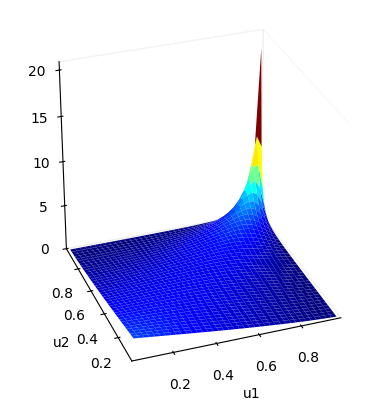

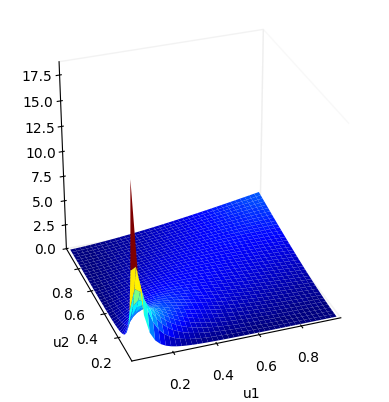

In [123]:
BestCop.plot()
ClaytonCop.plot()

2D contour plot of PDF. Again, the quantiles are reversed for the Clayton copula.

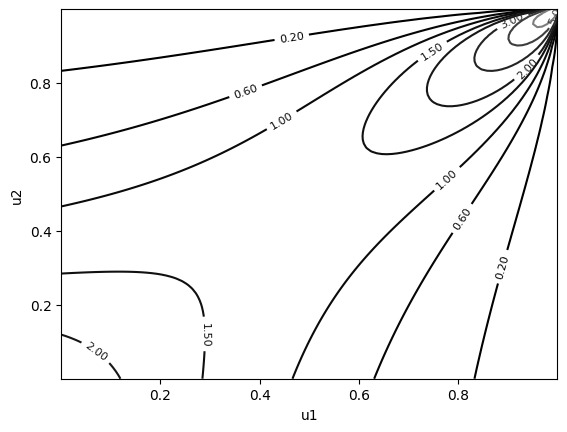

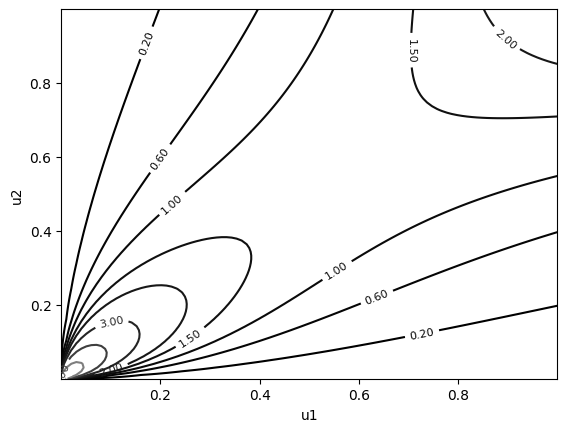

In [124]:
BestCop.plot(type="contour")
ClaytonCop.plot(type="contour")

Repeat with color for the Joe Copula.

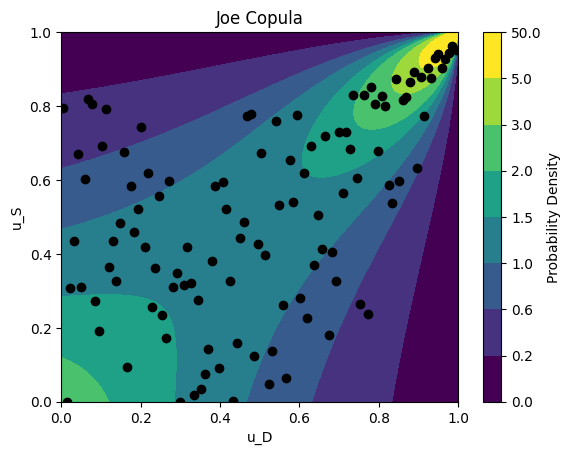

In [87]:
import matplotlib as mpl

# compute the PDF over a grid of u-space values
x, y = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
coordinates = np.stack((x,y), axis=-1).reshape(-1, 2)
prob = BestCop.pdf(coordinates).reshape(x.shape)

# create a linear segmented colormap
cmap = mpl.colormaps.get_cmap("viridis")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the contour levels and normalize the colormap to those levels
levels = [0,0.2,0.6,1,1.5,2,3,5,50]
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

# creat the contour map
colors = plt.contourf(x, y, prob, cmap=cmap, norm=norm, levels=levels)
plt.scatter(u_D, u_S, c='k')
plt.xlim(0,1)
plt.ylim(0,1)
cbar = plt.colorbar(colors)
cbar.set_label('Probability Density')
plt.xlabel('u_D')
plt.ylabel('u_S')
plt.title('Joe Copula')
plt.show()

And for the Clayton copula. With our own function, we can reverse the quantiles so it's more interpretable.

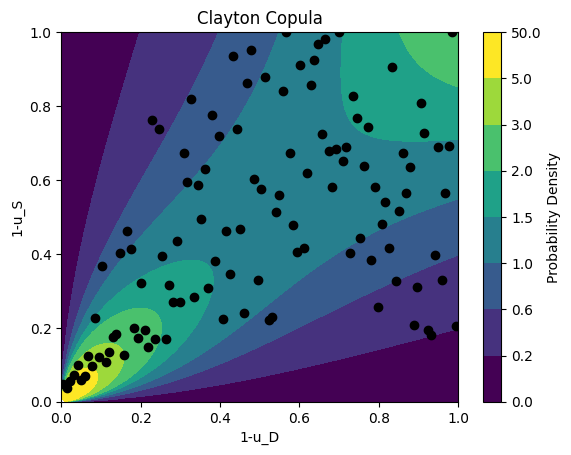

In [125]:
prob = ClaytonCop.pdf(coordinates).reshape(x.shape)

# creat the contour map
colors = plt.contourf(x, y, prob, cmap=cmap, norm=norm, levels=levels)
plt.scatter(1-u_D, 1-u_S, c='k')
plt.xlim(0,1)
plt.ylim(0,1)
cbar = plt.colorbar(colors)
cbar.set_label('Probability Density')
plt.xlabel('1-u_D')
plt.ylabel('1-u_S')
plt.title('Clayton Copula')
plt.show()

Repeat for the CDF.

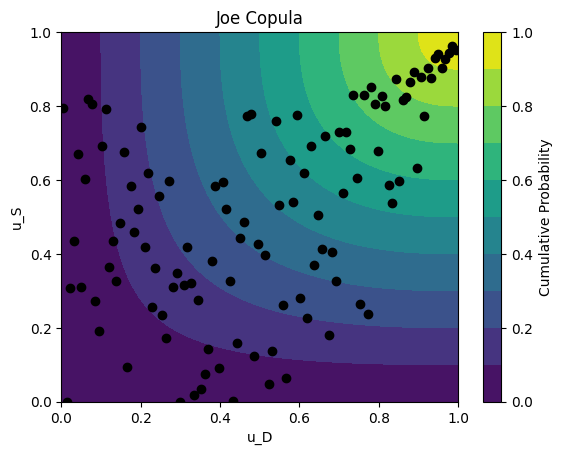

In [126]:
cumprob = BestCop.cdf(coordinates).reshape(x.shape)

colors = plt.contourf(x, y, cumprob, levels=np.arange(0,1.1,0.1))
plt.scatter(u_D, u_S, c='k')
plt.xlim(0,1)
plt.ylim(0,1)
cbar = plt.colorbar(colors)
cbar.set_label('Cumulative Probability')
plt.xlabel('u_D')
plt.ylabel('u_S')
plt.title('Joe Copula')
plt.show()

And for the Clayton copula.

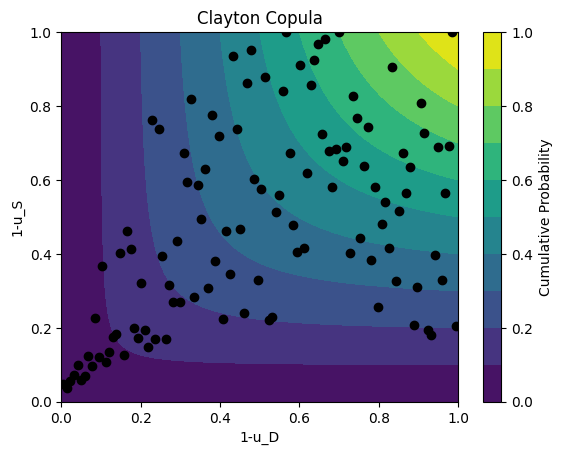

In [128]:
cumprob = ClaytonCop.cdf(coordinates).reshape(x.shape)

colors = plt.contourf(x, y, cumprob, levels=np.arange(0,1.1,0.1))
plt.scatter(1-u_D, 1-u_S, c='k')
plt.xlim(0,1)
plt.ylim(0,1)
cbar = plt.colorbar(colors)
cbar.set_label('Cumulative Probability')
plt.xlabel('1-u_D')
plt.ylabel('1-u_S')
plt.title('Clayton Copula')
plt.show()

## Computing Return Periods from Fitted Copula

Compute the return period of the most severe event using the Joe Copula.

In [129]:
OR_return = 1 / (1 - BestCop.cdf(np.array([u[np.argmax(u_S),:]]))[0])
AND_return = 1 / (1 - u_D[np.argmax(u_S)] - u_S[np.argmax(u_S)] + BestCop.cdf(np.array([u[np.argmax(u_S),:]]))[0])

print("OR return period: %0.2f" % OR_return)
print("AND return period: %0.2f" % AND_return)

OR return period: 26.33
AND return period: 78.90


Now using the Clayton copula. Since we fit the copula to 1-u, we'd want to know the probability of being below, not above that value in one or both variables.

In [131]:
AND_return = 1 / (BestCop.cdf(np.array([1-u[np.argmax(u_S),:]]))[0])
OR_return = 1 / ((1-u_D[np.argmax(u_S)]) + (1-u_S[np.argmax(u_S)]) - BestCop.cdf(np.array([1-u[np.argmax(u_S),:]]))[0])

print("OR return period: %0.2f" % OR_return)
print("AND return period: %0.2f" % AND_return)

OR return period: 20.22
AND return period: 836.36


This fit suggests that seeing a drought that is more severe than the most severe drought in terms of both duration and severity is much more unusual.

## Computing Conditional Distributions from Fitted Copula

Find the conditional distribution of drought severity given it lasts 3 years and compare with the unconditional distribution of severity using the Joe Copula.

<ipython-input-133-9ac6ba1d88c5>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_u_S[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)


Text(0, 0.5, 'Cumulative Probability')

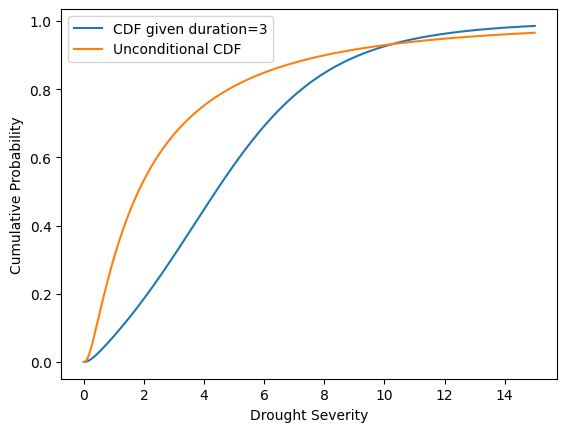

In [133]:
import seaborn as sns

u1 = np.mean(u_D[np.where(durations==3)[0]])

x = np.linspace(0,15,1000)
u2 = ss.lognorm.cdf(x, distfit.sigma, distfit.tau, np.exp(distfit.mu))
cond_u_S = np.empty(1000)
for i in range(len(u2)):
  cond_u_S[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)

# plot conditional vs. unconditional CDF
fig, ax = plt.subplots()
ax.plot(x, cond_u_S, label='CDF given duration=3')
ax.plot(x, ss.lognorm.cdf(x, distfit.sigma, distfit.tau, np.exp(distfit.mu)), label='Unconditional CDF')
ax.legend()
ax.set_xlabel("Drought Severity")
ax.set_ylabel("Cumulative Probability")

Repeat for the Clayton copula.

<ipython-input-136-85e26b8590d7>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_u_S[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)


Text(0, 0.5, 'Cumulative Probability')

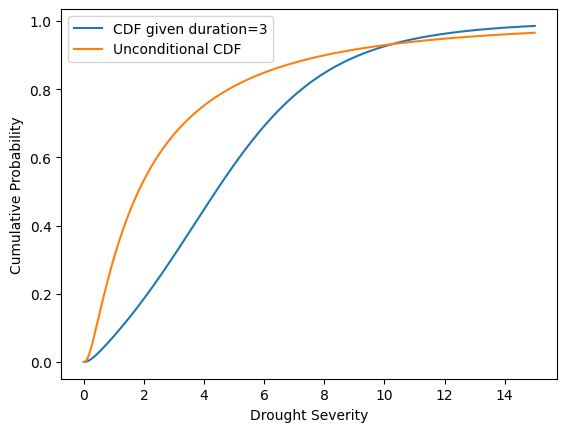

In [136]:
cond_u_S = np.empty(1000)
for i in range(len(u2)):
  cond_u_S[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)

fig, ax = plt.subplots()
ax.plot(x, cond_u_S, label='CDF given duration=3')
ax.plot(x, ss.lognorm.cdf(x, distfit.sigma, distfit.tau, np.exp(distfit.mu)), label='Unconditional CDF')
ax.legend()
ax.set_xlabel("Drought Severity")
ax.set_ylabel("Cumulative Probability")

These look remarkably similar. Let's plot the conditional distributions from each fit together.

<ipython-input-137-0e04ae21511a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_u_S_Joe[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)
<ipython-input-137-0e04ae21511a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cond_u_S_Clayton[i] = 1-ClaytonCop.hfunc1(np.array([[1-u1,1-u2[i]]])) # function to get P(u2<u2 | u1=u1)


Text(0, 0.5, 'Cumulative Probability')

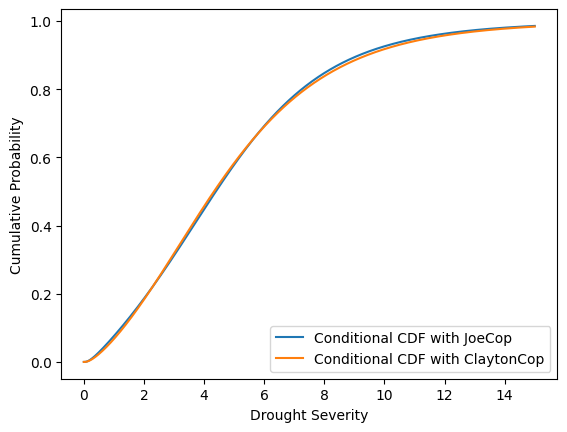

In [137]:
fig, ax = plt.subplots()

cond_u_S_Joe = np.empty(1000)
for i in range(len(u2)):
  cond_u_S_Joe[i] = BestCop.hfunc1(np.array([[u1,u2[i]]])) # function to get P(u2<u2 | u1=u1)

ax.plot(x, cond_u_S_Joe, label='Conditional CDF with JoeCop')

cond_u_S_Clayton = np.empty(1000)
for i in range(len(u2)):
  cond_u_S_Clayton[i] = 1-ClaytonCop.hfunc1(np.array([[1-u1,1-u2[i]]])) # function to get P(u2<u2 | u1=u1)

# plot conditional vs. unconditional CDF
ax.plot(x, cond_u_S_Clayton, label='Conditional CDF with ClaytonCop')
ax.legend()
ax.set_xlabel("Drought Severity")
ax.set_ylabel("Cumulative Probability")

They are very close! What does each suggest is the conditional and unconditional probability that the severity is at least 5 given the duration is 3 years?

In [138]:
p_Uncond_5 = 1 - ss.lognorm.cdf(5, distfit.sigma, distfit.tau, np.exp(distfit.mu))
p_Cond_5_Joe = cond_u_S_Joe[np.argmin(np.abs(x-5))]
p_Cond_5_Clayton = cond_u_S_Clayton[np.argmin(np.abs(x-5))]

print("Unconditional probability severity >= 5: %0.2f" % p_Uncond_5)
print("Probability severity >= 5 given duration = 3: %0.2f" % p_Cond_5_Joe)
print("Probability severity >= 5 given duration = 3: %0.2f" % p_Cond_5_Clayton)

Unconditional probability severity >= 5: 0.19
Probability severity >= 5 given duration = 3: 0.58
Probability severity >= 5 given duration = 3: 0.58


## Simulating from Fitted Copula

Generate 1000 drought durations and severities from the Joe copula and plot the simulated vs. observed values.

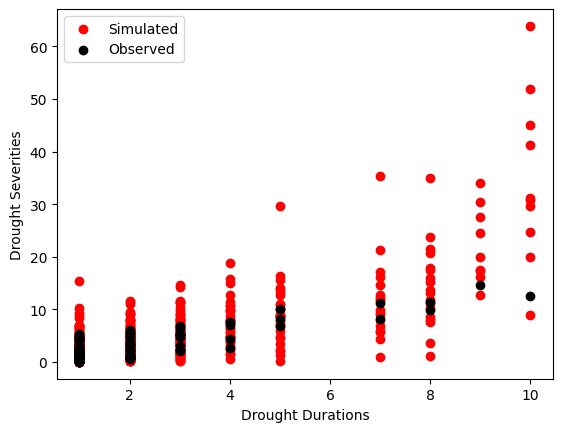

In [146]:
uSim = BestCop.simulate(1000, qrng=True, seeds=[1])

durSim = np.zeros(1000)
sevSim = np.zeros(1000)
for i in range(1000):
  durSim[i] = durations[np.argmin(np.abs(uSim[i,0]-u_D))]
  sevSim[i] = ss.lognorm.ppf(uSim[i,1], distfit.sigma, distfit.tau, np.exp(distfit.mu))

plt.scatter(durSim, sevSim, c='r', label='Simulated')
plt.scatter(durations, severities, c='k', label='Observed')
plt.legend()
plt.xlabel('Drought Durations')
plt.ylabel('Drought Severities')
plt.show()

Compare marginals

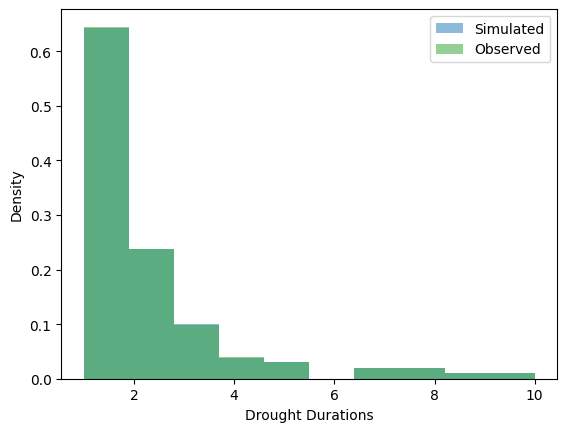

In [147]:
plt.hist(durSim, alpha=0.5, label='Simulated', color="tab:blue", density=True)
plt.hist(durations, alpha=0.5, label='Observed', color="tab:green", density=True)
plt.legend()
plt.xlabel('Drought Durations')
plt.ylabel('Density')
plt.show()

These are identical because we used the empirical distribution of drought duration.

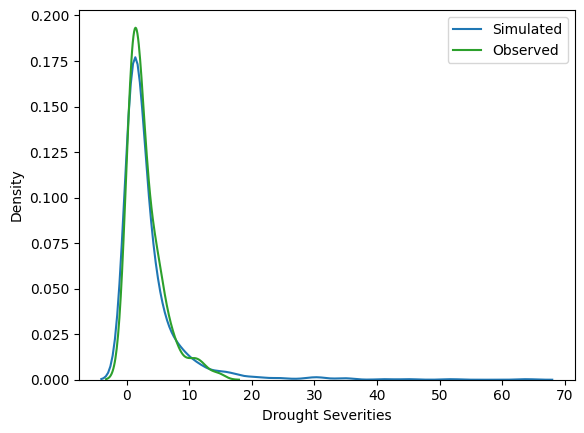

In [148]:
fig, ax = plt.subplots()
sns.kdeplot(sevSim, color="tab:blue", ax=ax)
sns.kdeplot(severities, color="tab:green", ax=ax)
ax.legend(labels=['Simulated', 'Observed'])
ax.set_xlabel('Drought Severities')
ax.set_ylabel('Density')
plt.show()

While there are some much more severe droughts generated than observed, the marginal distributions are in fact very close, so this is not unreasonable for generating 1000 droughts instead of the observed 112.

Repeat for the Clayton Copula

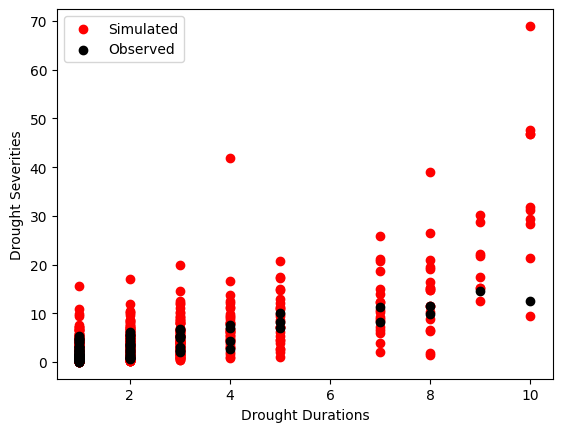

In [149]:
uSim = ClaytonCop.simulate(1000, qrng=True, seeds=[1])
# reverse quantiles
uSim = 1 - uSim

durSim = np.zeros(1000)
sevSim = np.zeros(1000)
for i in range(1000):
  durSim[i] = durations[np.argmin(np.abs(uSim[i,0]-u_D))]
  sevSim[i] = ss.lognorm.ppf(uSim[i,1], distfit.sigma, distfit.tau, np.exp(distfit.mu))

plt.scatter(durSim, sevSim, c='r', label='Simulated')
plt.scatter(durations, severities, c='k', label='Observed')
plt.legend()
plt.xlabel('Drought Durations')
plt.ylabel('Drought Severities')
plt.show()

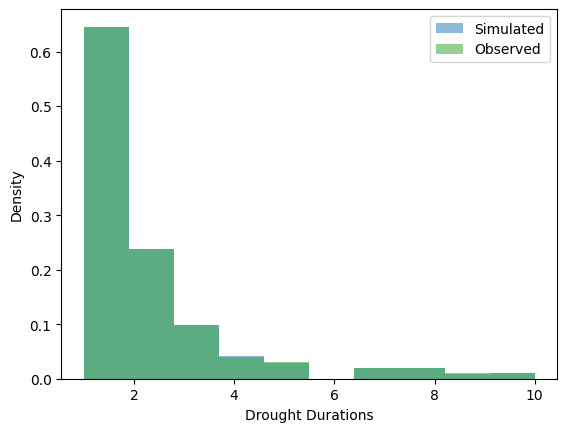

In [150]:
plt.hist(durSim, alpha=0.5, label='Simulated', color="tab:blue", density=True)
plt.hist(durations, alpha=0.5, label='Observed', color="tab:green", density=True)
plt.legend()
plt.xlabel('Drought Durations')
plt.ylabel('Density')
plt.show()

Again, this matches perfectly because we used the empirical distribution of drought duration.

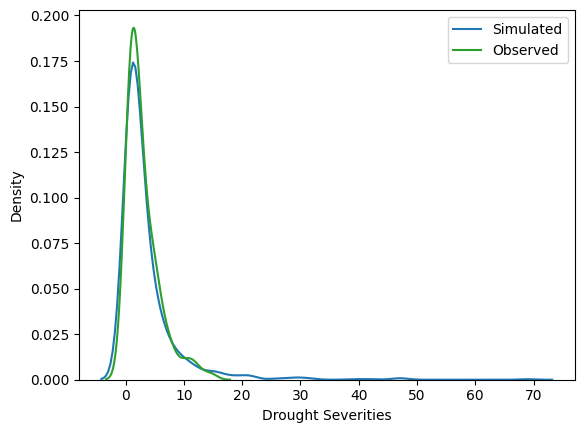

In [151]:
fig, ax = plt.subplots()
sns.kdeplot(sevSim, color="tab:blue", ax=ax)
sns.kdeplot(severities, color="tab:green", ax=ax)
ax.legend(labels=['Simulated', 'Observed'])
ax.set_xlabel('Drought Severities')
ax.set_ylabel('Density')
plt.show()

Again, while we simulated some droughts with much greater severity, the distribution is in fact reasonable.